In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from random import randrange

# Data for final consumption and total output

For this case study, we use the input-output data of Germany. The data for the initial output level and final consumption level per industry as well as the supply and demand shock data is taken from:

Pichler, A. and Farmer, J. D. (2021b). Simultaneous supply and demand constraints in
input–output networks: the case of covid-19 in Germany, Italy and Spain (Version V1).
Zenodo. https://doi.org/10.5281/zenodo.4326815

## Final consumption

**We define the initial and maximal consumption for each industry**

In [2]:
fdata = pd.read_csv('fdata_deu.csv', sep = ',')
fdata.head()
f_0 = fdata.iloc[:,1].astype('float')
f_max = np.array(fdata.iloc[:,3].astype('float'))

In [3]:
demand_shock = np.zeros(f_max.shape[0])
for i in range (0,f_max.shape[0]):
    demand_shock[i] = round(1- f_max[i]/f_0[i],3)
    
demand_shock = np.array(demand_shock)

## Total output

In [4]:
xdata =  pd.read_csv('xdata_deu.csv', sep = ',')
xdata.tail()   
x_0 = xdata.iloc[:,1].astype('float')
x_max = np.array(xdata.iloc[:,3].astype('float'))

In [5]:
supply_shock = np.zeros(x_max.shape[0])
for i in range (0,x_max.shape[0]):
    supply_shock[i] = round(1- x_max[i]/x_0[i],6)
    

# IO table 

In [6]:
df = pd.read_csv('deu_wiot.csv',sep = ',',low_memory=False)
df.head()
df = df.iloc[:,1:]# leaving out industries U and T
df = df.astype('float')
df.shape

(55, 55)

In [7]:
A = np.array(df)
N = A.shape[0]
A.shape

(55, 55)

In [8]:
L = np.linalg.inv(np.identity(N)-A)

In [9]:
Z = pd.read_csv('Zmatrix_deu.csv', sep=',', low_memory=False)
Z =  Z.iloc[:,1:]# leaving out industries U and T
Z = Z.astype('float')
Z = np.array(Z)
N = Z.shape[0]

In [10]:
x_0 = np.array(x_0)
f_0 = np.array(f_0)

# Optimalization

### Maximizing total output

In [11]:
def max_output(N,L,A,xmax,fmax):
    z = np.ones(N)
    obj = -np.matmul(np.matrix.transpose(z), L)
    lhs_ineq = np.concatenate((-L,L))
    rhs_ineq = np.concatenate((np.zeros(N), xmax))
    
    bnd = []
    for i in range (0,N):
        bnd.append((0,fmax[i]))
    
    result = linprog(c = obj, A_ub= lhs_ineq, b_ub= rhs_ineq, bounds = bnd)
    
    optimal_output = -result.fun
    
    optimal_f = np.ones(N)
    for i in range(0,N):
        optimal_f[i] = result.x[i]
    
    return result.success, optimal_output/sum(x_0), sum(optimal_f)/sum(f_0)

In [12]:
max_output(N,L,A,x_max,f_max)

(True, 0.6251353593714393, 0.6320096267938023)

### Maximizing final consumption

In [13]:
def max_consumption(N,L,A,xmax,fmax):
    z = np.ones(N)
    obj2 = -np.matmul(np.matrix.transpose(z), np.identity(N)-A)
    lhs_ineq2 = np.concatenate((-(np.identity(N)-A), np.identity(N)-A))
    rhs_ineq2 = np.concatenate((np.zeros(N), fmax))
    
    bnd2 = []
    for i in range (0,N):
        bnd2.append((0,xmax[i]))
        
    result2 = linprog(c = obj2, A_ub= lhs_ineq2, b_ub= rhs_ineq2, bounds= bnd2)
    optimal_f_2 = -result2.fun
    
    optimal_output_2 = np.ones(N)
    for i in range(0,N):
        optimal_output_2[i] = round(result2.x[i])
        
    return result2.success, sum(optimal_output_2)/sum(x_0), optimal_f_2/sum(f_0)

**Note that both optimization problems give almost the same solution**

# Rationing

In [14]:
f_max = f_max[:54]
x_max = x_max[:54]
A = A[:54,:54]
Z = Z[:54,:54]
N = 54
x_0 = x_0[:54]
f_0 = f_0[:54]

L = np.linalg.inv(np.identity(N)-A)
supply_shock = np.array(supply_shock[:54])
demand_shock = np.array(demand_shock[:54])

## Propotional Rationing

In [15]:
def algo_proportional(A, L, fmax, xmax, TT, prioritize="no"):
    x = [0]
    fvec = []          # initial demand vector
    fvec.append(fmax)
    r = [0]            # output constraints
    s = [0]            # input bottlenecks 
    d = [0]            # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]
    x_ = [0]
    
    list_ = [1] 
    t=1
    epsilon = 1e-6
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        r.append(np.ones(len(xmax)))
        s.append(np.ones(len(xmax)))
        fvec.append(np.ones(len(xmax)))
        x.append(np.ones(len(xmax)))
        d.append(np.ones(len(xmax)))
        x_.append(np.ones(len(xmax)))
        ##########################################
        ########### Output constraints ###########
        ##########################################
        for i in range (0,len(x_max)):
            r[t][i] = xmax[i]/d[t][i]
        #print('Output constraints:{}'.format(r[t]))
        
        ##########################################
        ########### Input bottlenecks ############
        ##########################################
        for i in range(0,len(x_max)):
            for j in range(0,len(x_max)):
                if A[j][i] > 0: 
                    list_.append(r[t][j])
            s[t][i] = min(list_)
            list_ = [1]
        #print('Input bottlenecks:{}'.format(s[t]))
        
        ##############################################
        ########### Constrained Production ###########
        ##############################################
        for i in range(0,len(xmax)):
            x_[t][i] = s[t][i]*d[t][i]
            x[t][i] = min(xmax[i],x_[t][i])
        #print('Constrained production:{}'.format(x[t]))
            
        ##############################################
        ############ Constrained Delivery ############
        ##############################################
        for i in range(0,len(xmax)):
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],x_[t]),0)
        #print('Constrained delivery:{}'.format(fvec[t]))
        
        ###############################################
        ############ New Aggregated Demand ############
        ###############################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
        t=t+1
        #print('Aggregated Demand:         {}'.format(d[t]))
        if t == TT:
            print("Algoritm did not converge")
            
    return sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t


## Mixed priority/proportional rationing

In [16]:
def algo_mixed(A, L, fmax, xmax, TT,prioritize="yes"):
    x = [0]
    fvec = [] # initial demand vector
    fvec.append(fmax)
    r = [0]   # output constraints
    s = [0]   # input bottlenecks 
    d = [0]   # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]
    x_ = [0]
    
    list_ = [1] 
    t=1
    epsilon = 1e-6
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        r.append(np.ones(len(xmax)))
        s.append(np.ones(len(xmax)))
        fvec.append(np.ones(len(xmax)))
        x.append(np.ones(len(xmax)))
        d.append(np.ones(len(xmax)))
        x_.append(np.ones(len(xmax)))
        ##########################################
        ########### Output constraints ###########
        ##########################################
        for i in range (0,len(x_max)):
            denominator = np.matmul(A[i],d[t])
            if denominator == 0:
                r[t][i] = 1 
            else:
                r[t][i] = xmax[i]/denominator
        #print('Output constraints:         {}'.format(r[t]))
        
        ##########################################
        ########### Input bottlenecks ############
        ##########################################
        for i in range(0,len(x_max)):
            for j in range(0,len(x_max)):
                if A[j][i] > 0:
                    list_.append(r[t][j])
            s[t][i] = min(list_)
            list_ = [1]
        #print('Input bottlenecks:         {}'.format(s[t]))
        
        ##############################################
        ########### Constrained Production ###########
        ##############################################
        for i in range(0,len(xmax)):
            x_[t][i] = s[t][i]*d[t][i]
            x[t][i] = min(xmax[i], x_[t][i])
            #print(s[t][i]*d[t][i])
            
            
        ##############################################
        ############ Constrained Delivery ############
        ##############################################
        
        for i in range(0,len(xmax)):
            
            #print(np.matmul(A[i],s[t]*d[t]))
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],x_[t]),0) 
        #print('Constrained delivery:      {}'.format(fvec[t]))
        
        ###############################################
        ############ New Aggregated Demand ############
        ###############################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
        t=t+1
    
    if t == TT:
        print("Algoritm did not converge")
        
    return sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t

## Priority rationing

In [17]:
def order(A, L, fmax):
    d = np.matmul(L, fmax)
    list_1 = []      # list we will sort
    list_2 = []      # list that will not be sorted to find the original indices
    for i in range(A.shape[0]):
        list_1.append([])
        list_2.append([])
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            list_1[i].append(A[i][j]*d[j])    # list_1[i][j] = list_2[i][j] = A[i][j]*d[j]
            list_2[i].append(A[i][j]*d[j])
        list_1[i].sort(reverse = True)        # we sort list_1: A[i][j]*d[j] >= A[i][j+1]*d[j+1]

    names_ordered=[]
    for i in range(A.shape[0]):
        names_ordered.append([])
    
    for i in range(A.shape[0]):
        for k in list_1[i]:                  # we take the indices of the j+1 (j from 0 to N-1) biggest suppliers of industry i. 
                for l in range(A.shape[0]):    
                    if list_2[i][l] == k:
                        names_ordered[i].append(l)   
    return names_ordered

In [18]:
def algo_priority(A, L, fmax, xmax, ordered, TT,  prioritize="yes"):               
    x = [0]
    fvec = []   # initial demand vector
    fvec.append(fmax)
    rvec = [0]  # output constraints
    s = [0]     # input bottlenecks 
    d = [0]     # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]
    x_ = [0]
    
    list_ = [1] 
    t=1
    epsilon = 1e-7
    
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        rvec.append([np.zeros(N)])
        s.append(np.ones(N))
        fvec.append(np.ones(N))
        x.append(np.ones(N))
        d.append(np.ones(N))
        demand = np.identity(N)
        x_.append(np.ones(N))
        
        som = 0
        for i in range(0,N):
            for j in range(0,N):
                for k in ordered[i][:j+1]:
                    som = som + A[i][k]*d[t][k] 
                demand[i][j] = som   #demand[i][j] = demand of j'th biggest customers of firm i summed up
                som = 0
        remainder = np.identity(N)
    
        for i in range(0,N):
            for j in range(0,N):
                remainder[i][j] = xmax[i] - demand[i][j]
                
        ####################################################
        ####################### rvec #######################
        ####################################################
        for i in range(0,N):
            rvec[t].append([])
        for i in range(0,N):
            if all(remainder[i][j]>0 for j in range(0,N)):
                rvec[t][i] = np.ones(N) 
            elif all(remainder[i][j]<=0 for j in range(0,N)): 
                rvec[t][i] = np.zeros(N)
                for k in ordered[i][:1]: 
                    rvec[t][i][k] = xmax[i]/demand[i][0]
        
            else: 
                idx = np.where(remainder[i]<=0) # index for partially met demand
                idx_fully = np.where(remainder[i]>0) 
                length = len(idx_fully[0])
                rvec[t][i] = np.zeros(N)
                for l in range(0,length-1):
                    index = ordered[i][l]
                    rvec[t][i][index] = 1
                m = ordered[i][length-1]
                rvec[t][i][m] = remainder[i][length-1]/(demand[i][length]-demand[i][length-1])
                
        #####################################################
        ################# Input bottlenecks #################
        #####################################################
        for i in range(0,N):
            for j in range(0,N):
                if A[j][i]>0:
                    list_.append(rvec[t][j][i])
            s[t][i] = min(list_)
            list_ = [1]   
        #print('Input bottlenecks:         {}'.format(s[t]))
        
        ######################################################
        ############### Constrained Production ###############
        ######################################################
        for i in range(0,N):
            x_[t][i] = s[t][i]*d[t][i]
            x[t][i] = min(xmax[i], x_[t][i])
            
            
        ######################################################
        ################ Constrained Delivery ################
        ######################################################
        for i in range(0,len(xmax)):
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],x_[t]),0)
        
        ######################################################
        ################ Aggregated demand ###################
        ######################################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
            
        t=t+1
        
        if t==TT:
            print("Algorithm did not converge")
    return sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t

## Random rationing

Suppliers rank their customers randomly. The computations for this algorithm are the same as for
the priority rationing method. The only difference is the ranking $h_{ij}$ of the customers of
each industry $i$, which is now randomly taken. We implement the rationing algorithm
by taking the average from $100$ samples.

In [19]:
def algo_random(A, L, fmax, xmax, runs, prioritize = "random"):
    x = []
    y = []
    while len(x)<runs:
        random_ordered=[]
        for i in range(N):
            random_ordered.append([])
    
        for i in range(N):
            while len(random_ordered[i])<N:
                random = randrange(N)
                while random in random_ordered[i]:
                    random = randrange(N) # We take the indices of the j+1 ( with j from 0 to N-1) biggest suppliers  
                random_ordered[i].append(random)

        result = algo_priority(A, L, fmax, xmax, random_ordered, 25, prioritize="yes")
        if result[2] < 30:
            result_x = result[0]
            result_y = result[1]
            t = result[2]
        
            x.append(result_x)
            y.append(result_y)
        
    result_random = (sum(x)/len(x), sum(y)/len(y), t)
    return result_random

# Shock Magnitude Effect

We now investigate how these results depend on the magnitude of the initial shocks. We follow
the approach of Pichler and Farmer, who have done this by rescaling supply and demand shocks and then applying the optimization methods and the rationing algorithms to the new shock data. By doing this for various shocks scales, we can investigate how the
impact predictions change in function of the shock scale. We use different scaling factors for demand and supply constraints:

$$ x^{max}_i = (1-\alpha^S\varepsilon_i^S)x_{i,0}$$

$$ f^{max}_i = (1-\alpha^D\varepsilon_i^D)f_{i,0}$$

Where $\alpha^S$ and $\alpha^D$ lie between $0$ and $1$. 

In [20]:
def shockscale(x, xmax, f, fmax, scale_x, scale_f):
    ss_full = np.divide(xmax,x)-1
    ds_full = np.divide(fmax,f)-1
    
    ss = ss_full*scale_x
   
    x_shocked = np.zeros(N)
    
    for i in range (0,N):
        x_shocked[i] = (np.ones(N)+ ss)[i]*x[i]

    
    ds = ds_full*scale_f
    f_shocked = np.zeros(N)
    
    for i in range (0,N):
        f_shocked[i] = (np.ones(N)+ ds)[i]*f[i]
    
    return x_shocked, f_shocked

### Direct shocks

In [21]:
def scale_run_direct_shock(scalewhat = "both", seq = np.linspace(0,1,100)):    
    res_dir_x = []
    res_dir_f = []
    for i in range(0, len(seq)):
        if scalewhat == "both":
            scaleres = shockscale(x_0, x_max, f_0, f_max, scale_x=seq[i], scale_f=seq[i])
            
        if scalewhat == "supply":
            scaleres = shockscale(x_0, x_max, f_0, f_max, scale_x=seq[i], scale_f=0)
            
        if scalewhat == "demand":
            scaleres = shockscale(x_0, x_max, f_0, f_max, scale_x=0, scale_f=seq[i])
            
    
        res_dir_x.append(sum(scaleres[0])/sum(x_0))
        res_dir_f.append(sum(scaleres[1])/sum(f_0)) 
    dataframe = {'x': res_dir_x,
                 'f': res_dir_f,
                'Scale': scalewhat, 'Algorithm': 'Direct_shock', 'a': seq}
    df = pd.DataFrame(dataframe)
        
    return df

In [22]:
x_direct_D = np.array(scale_run_direct_shock(scalewhat = "demand",  seq = np.linspace(0,1,100)).iloc[:,0].astype('float'))

### Rationing

In [23]:
TT = 25

In [24]:
def scale_run_rationing(scalewhat = "both",  seq = np.linspace(0,1,100)):
    res1x = []
    res1f = []
    
    res2x = []
    res2f = []
    
    res3x = []
    res3f = []
    i=0
    while i <len(seq):
        if scalewhat == "both":
            scaleres = shockscale(x_0, x_max, f_0, f_max,scale_x=seq[i], scale_f=seq[i])
            
        if scalewhat == "supply":
            scaleres = shockscale(x_0, x_max, f_0, f_max,scale_x=seq[i], scale_f=0)
            
        if scalewhat == "demand":
            scaleres = shockscale(x_0, x_max, f_0, f_max,scale_x=0, scale_f=seq[i])
        
        res1 = algo_proportional(A, L, scaleres[1], scaleres[0], 25, prioritize = "no")
        res2 = algo_mixed(A, L, scaleres[1], scaleres[0], 100, prioritize="yes")
        
        names_ordered = order(A,L,scaleres[1])
        res3 = algo_priority(A, L, scaleres[1], scaleres[0], names_ordered, 25, prioritize="yes")            
                
        if res1[2] != 25:
            res1x.append(res1[0])
            res1f.append(res1[1])
        else:
            res1x.append('NaN')
            res1f.append('NaN')
        
        if res2[2] != 25:
            res2x.append(res2[0])
            res2f.append(res2[1])
        else:
            res2x.append('NaN')
            res2f.append('NaN')
            
        if res3[2] != 25:
            res3x.append(res3[0])
            res3f.append(res3[1])
                
        else:
            res3x.append('NaN')
            res3f.append('NaN')
        i = i+1
    
    dataframe1 = {'x': res1x, 'f': res1f, 'Scale': scalewhat, 'Algorithm': 'Proportional', 'a': seq }
    df1 = pd.DataFrame(dataframe1)
    
    dataframe2 = {'x': res2x, 'f': res2f, 'Scale': scalewhat, 'Algorithm': 'Mixed', 'a': seq }
    df2 = pd.DataFrame(dataframe2)
    
    dataframe3 = {'x': res3x, 'f': res3f, 'Scale': scalewhat, 'Algorithm': 'Priority', 'a': seq }  
    df3 = pd.DataFrame(dataframe3)
    
    return df1, df2, df3

In [25]:
def scale_run_random_rationing(scalewhat = "both", seq = np.linspace(0,1,100)):
    res4x = []
    res4f = []
    i=0
    while i < len(seq):
        if scalewhat == "both":
            scaleres = shockscale(x_0, x_max, f_0, f_max,scale_x=seq[i], scale_f=seq[i])
            
        if scalewhat == "supply":
            scaleres = shockscale(x_0, x_max, f_0, f_max,scale_x=seq[i], scale_f=0)
            
        if scalewhat == "demand":
            scaleres = shockscale(x_0, x_max, f_0, f_max,scale_x=0, scale_f=seq[i])
        
        
        res4 = algo_random(A, L, scaleres[1], scaleres[0], 50, prioritize = "random")
        res4x.append(res4[0])
        res4f.append(res4[1]) 
        
        print(i)
        i = i+1
    
    dataframe4 = {'x': res4x, 'f': res4f, 'Scale': scalewhat, 'Algorithm': 'Random', 'a': seq}  
    df4 = pd.DataFrame(dataframe4)
    
    return df4

### Optimization

**Optimizing output**

In [26]:
def scale_run_optimizationX(scalewhat = "both", runs = 100, seq = np.linspace(0,1,100)):
    resmax_output_x = []
    resmax_output_f = []
    
    i=0
    while i <len(seq):
        if scalewhat == "both":
            scaleres = shockscale(x_0, x_max, f_0, f_max, scale_x=seq[i], scale_f=seq[i])
            
        if scalewhat == "supply":
            scaleres = shockscale(x_0, x_max, f_0, f_max, scale_x=seq[i], scale_f=0)
            
        if scalewhat == "demand":
            scaleres = shockscale(x_0, x_max, f_0, f_max, scale_x=0, scale_f=seq[i])
        
        #print(scaleres[0])
        resmaxX = max_output(N , L, A, xmax = scaleres[0], fmax=scaleres[1])
        #print(resmaxX)
        if resmaxX[0] == True:
        #print(resmaxX)
            resmax_output_x.append(resmaxX[1])
            resmax_output_f.append(resmaxX[2])
        else: 
            resmax_output_x.append('NaN')
            resmax_output_f.append('NaN')
            
            
        i = i+1
        
        
    dataframe = {'x': resmax_output_x,
                 'f': resmax_output_f,
                'Scale': scalewhat, 'Algorithm': 'Max_output', 'a': seq}
    df = pd.DataFrame(dataframe)
    
    return df

**Optimizing consumption**

In [27]:
def scale_run_optimizationF(scalewhat = "both", seq = np.linspace(0,1,100)):

    resmax_consumption_x = []
    resmax_consumption_f = []
    
    i=0
    while i <len(seq):
        if scalewhat == "both":
            scaleres = shockscale(x_0, x_max, f_0, f_max, scale_x=seq[i], scale_f=seq[i])
            
        if scalewhat == "supply":
            scaleres = shockscale(x_0, x_max, f_0, f_max, scale_x=seq[i], scale_f=0)
            
        if scalewhat == "demand":
            scaleres = shockscale(x_0, x_max, f_0, f_max, scale_x=0, scale_f=seq[i])
        
        
            
        resmaxF = max_consumption(N , L, A, xmax = scaleres[0], fmax=scaleres[1])
        #print(resmaxX)
        if resmaxF[0] == True:
        #print(resmaxX)
            resmax_consumption_x.append(resmaxF[1])
            resmax_consumption_f.append(resmaxF[2])
        else: 
            resmax_consumption_x.append(NaN)
            resmax_consumption_f.append(NaN)
        
        i = i+1
        
        
    dataframe = {'x': resmax_consumption_x,
                 'f': resmax_consumption_f,
                'Scale': scalewhat, 'Algorithm': 'Max_consumption', 'a': seq}
    df = pd.DataFrame(dataframe)
    
    return df

In [28]:
x_opt_D = np.array(scale_run_optimizationX(scalewhat = "demand",  seq = np.linspace(0,1,100)).iloc[:,0].astype('float'))

# Results

## No supply shocks

We first investigate the impact of the demand shock magnitude on the economic impact
predictions. To do this, we set $\alpha^S = 0$ and we let $\alpha^D$ range between 0 and 1. For 100
different values of $\alpha^D$, we apply the optimization methods and the rationing algorithms
to the new shock data.

In [29]:
alpha = np.linspace(0,1,100)

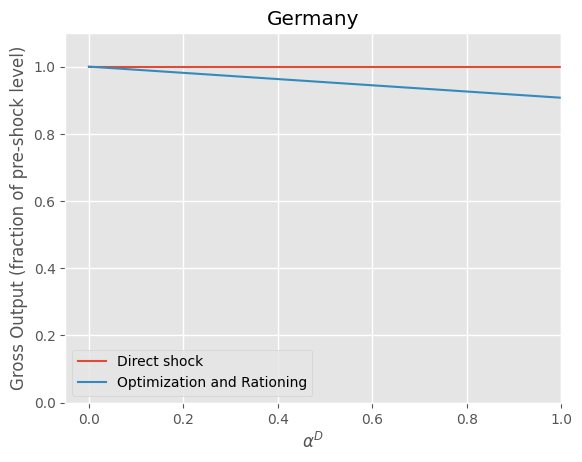

In [30]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.title("Germany")
plt.grid(visible=None, which='major', axis='both', linestyle='-', linewidth=1)
plt.plot(alpha, x_direct_D)
plt.plot(alpha, x_opt_D)
plt.xlim(-0.05, 1) 
plt.ylim(-0.00,1.1)

#plt.rcParams['text.usetex'] = True
plt.xlabel(r'$\alpha^D$')
plt.ylabel("Gross Output (fraction of pre-shock level)")
plt.legend(['Direct shock', 'Optimization and Rationing'])
plt.savefig('plot_deu_scale_demand.png')

## No demand shocks

We now look at what happens if we only rescale the supply shock and set $\alpha^D = 0$.

In [31]:
result_direct = scale_run_direct_shock(scalewhat = "both",  seq = np.linspace(0,1,100)) 
x_direct = np.array(result_direct.iloc[:,0].astype('float'))
alpha = np.array(result_direct.iloc[:,4].astype('float'))

result_opt = scale_run_optimizationX(scalewhat = "both", runs = 100, seq = np.linspace(0,1,100)) 
x_opt= np.array(result_opt.iloc[:,0].astype('float'))

result = scale_run_rationing(scalewhat = "both",  seq = np.linspace(0,1,100))

result_prop = result[0] 
x_prop = np.array(result_prop.iloc[:,0].astype('float'))

result_mixed = result[1] 
x_mixed = np.array(result_mixed.iloc[:,0].astype('float'))

result_priority = result[2]
x_priority = np.array(result_priority.iloc[:,0].astype('float'))

In [35]:
result_random = scale_run_random_rationing(scalewhat = "both", seq = np.linspace(0,1,100))
x_random = np.array(result_random.iloc[:,0].astype('float'))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


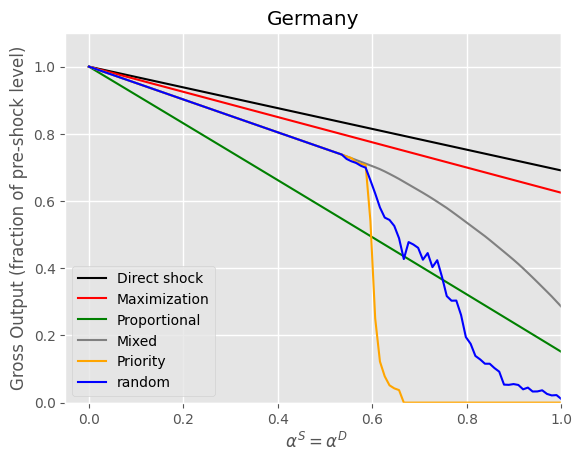

In [34]:
plt.style.use('ggplot')
plt.title("Germany")
plt.grid(visible=None, which='major', axis='both', linestyle='-', linewidth=1)

plt.plot(alpha, x_direct, 'black')
plt.plot(alpha, x_opt, 'red')
plt.plot(alpha, x_prop, 'green')
plt.plot(alpha, x_mixed, 'grey')
plt.plot(alpha, x_priority, 'orange')
plt.plot(alpha, x_random, 'blue')

plt.xlim(-0.05, 1) 
plt.ylim(-0.00,1.1)
#plt.rcParams['text.usetex'] = True
plt.xlabel(r' $\alpha^S = \alpha^D$')
plt.ylabel("Gross Output (fraction of pre-shock level)")
plt.legend(['Direct shock', 'Maximization', 'Proportional', 'Mixed', 'Priority', 'random'])
plt.savefig('plot_deu_scale.png')